In [1]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [4]:
data_dir= ''
model_name = 'vgg'
num_classes = 10
batch_size = 1
num_epochs = 40
feature_extract = True

In [5]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

In [6]:
batch_size = 1


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

GTZAN_data = pickle.load(open('GTZAN.train', 'rb'))
trainset = GTZANDataset(GTZAN_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

GTZAN_data = pickle.load(open('GTZAN.test', 'rb'))
testset = GTZANDataset(GTZAN_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


In [7]:
# dataloaders_dict = {'train': trainloader, 'test':testloader}

In [8]:
# [resnet, alexnet, vgg, squeezenet, densenet]

In [9]:
def train_model(model, dataloaders,criterion, opt, epochs):
    since = time.time()
    avg_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print_freq = 100
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
       


        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            opt.zero_grad()
             # forward
            # track history if only in train
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            opt.step()
        # statistics
            running_loss += loss.item() 
            
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                losses = running_loss / print_freq
                
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, losses))
                avg_loss.append(losses)
                
                running_loss = 0.0
    
                

            
            # deep copy the model
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, avg_loss

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        
        
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224 # what does it mean?
        

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [11]:
model_ft = model_ft.to(device)

In [12]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft,avg_loss = train_model(model_ft, trainloader, 
                             criterion, optimizer_ft, epochs=num_epochs)

Epoch 0/39
----------
[epoch: 0, i:    99] avg mini-batch loss: 2.358
[epoch: 0, i:   199] avg mini-batch loss: 2.228
[epoch: 0, i:   299] avg mini-batch loss: 2.143
[epoch: 0, i:   399] avg mini-batch loss: 2.169
[epoch: 0, i:   499] avg mini-batch loss: 1.946
[epoch: 0, i:   599] avg mini-batch loss: 2.013
[epoch: 0, i:   699] avg mini-batch loss: 1.944
[epoch: 0, i:   799] avg mini-batch loss: 1.909
Epoch 1/39
----------
[epoch: 1, i:    99] avg mini-batch loss: 1.812
[epoch: 1, i:   199] avg mini-batch loss: 1.680
[epoch: 1, i:   299] avg mini-batch loss: 1.551
[epoch: 1, i:   399] avg mini-batch loss: 1.693
[epoch: 1, i:   499] avg mini-batch loss: 1.705
[epoch: 1, i:   599] avg mini-batch loss: 1.575
[epoch: 1, i:   699] avg mini-batch loss: 1.526
[epoch: 1, i:   799] avg mini-batch loss: 1.415
Epoch 2/39
----------
[epoch: 2, i:    99] avg mini-batch loss: 1.372
[epoch: 2, i:   199] avg mini-batch loss: 1.249
[epoch: 2, i:   299] avg mini-batch loss: 1.647
[epoch: 2, i:   399] a

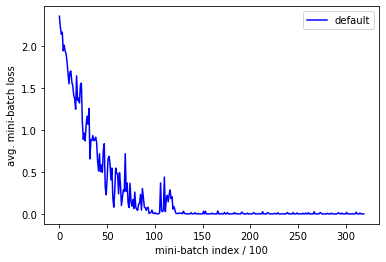

In [14]:
plt.plot(avg_loss, 'b', label='default')
print_freq = 100
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend()
plt.show()

In [15]:
correct = 0

total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
       
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Net: Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Net: Accuracy of the network on the 10000 test images: 11 %


In [16]:
classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')
preds_net = []

truths = []

# Get test accuracy for each class.
class_correct_net = list(0. for i in range(10))

class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs_net = model_ft(images)
        
        _, predicted_net = torch.max(outputs_net, 1)
        
        c_net = (predicted_net == labels).squeeze()
        
        if type(c_net) is not list:
            c_net = [c_net]
            
        for i in range(batch_size):
            preds_net.append(predicted_net[i].item())
            
            truths.append(labels[i].item())
#             confusion_matrix[actual][pred_net] += 1
#             confusion_matrix_cnn[actual][pred_cnn] += 1
            
            label = labels[i]
            class_correct_net[label] += c_net[i].item()
            
            class_total[label] += 1

for i in range(10):
    print('Net Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct_net[i] / class_total[i]))


Net Accuracy of blues :  0 %
Net Accuracy of classical : 13 %
Net Accuracy of country :  8 %
Net Accuracy of disco :  7 %
Net Accuracy of hiphop :  0 %
Net Accuracy of  jazz :  0 %
Net Accuracy of metal :  0 %
Net Accuracy of   pop : 20 %
Net Accuracy of reggae : 26 %
Net Accuracy of  rock : 40 %
